# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [10]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.330054
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.720162 analytic: 1.720162, relative error: 2.585605e-08
numerical: -0.388451 analytic: -0.388451, relative error: 9.327491e-08
numerical: 1.512885 analytic: 1.512885, relative error: 2.324279e-09
numerical: -2.570819 analytic: -2.570819, relative error: 1.242687e-08
numerical: -1.071965 analytic: -1.071965, relative error: 1.541029e-08
numerical: 0.738429 analytic: 0.738428, relative error: 7.517063e-08
numerical: 0.121492 analytic: 0.121492, relative error: 2.747695e-07
numerical: 2.719882 analytic: 2.719882, relative error: 3.976705e-08
numerical: -0.051057 analytic: -0.051057, relative error: 2.303007e-07
numerical: 0.627114 analytic: 0.627114, relative error: 1.056884e-08
numerical: 0.203260 analytic: 0.203260, relative error: 7.280889e-08
numerical: 2.134734 analytic: 2.134734, relative error: 3.546375e-08
numerical: 3.712615 analytic: 3.712615, relative error: 1.138191e-08
numerical: 3.296529 analytic: 3.296529, relative error: 2.910399e-08
numerical: -2.101375 analy

In [14]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.330054e+00 computed in 0.054675s
vectorized loss: 2.330054e+00 computed in 0.007133s
Loss difference: 0.000000
Gradient difference: 0.000000


In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
smx = Softmax()
tic = time.time()
loss_hist = smx.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 779.238440
iteration 100 / 1500: loss 286.209093
iteration 200 / 1500: loss 105.964897
iteration 300 / 1500: loss 40.096627
iteration 400 / 1500: loss 16.011841
iteration 500 / 1500: loss 7.243756
iteration 600 / 1500: loss 3.949876
iteration 700 / 1500: loss 2.807941
iteration 800 / 1500: loss 2.347514
iteration 900 / 1500: loss 2.221700
iteration 1000 / 1500: loss 2.100837
iteration 1100 / 1500: loss 2.099740
iteration 1200 / 1500: loss 2.084243
iteration 1300 / 1500: loss 2.062129
iteration 1400 / 1500: loss 2.044253
That took 4.368505s


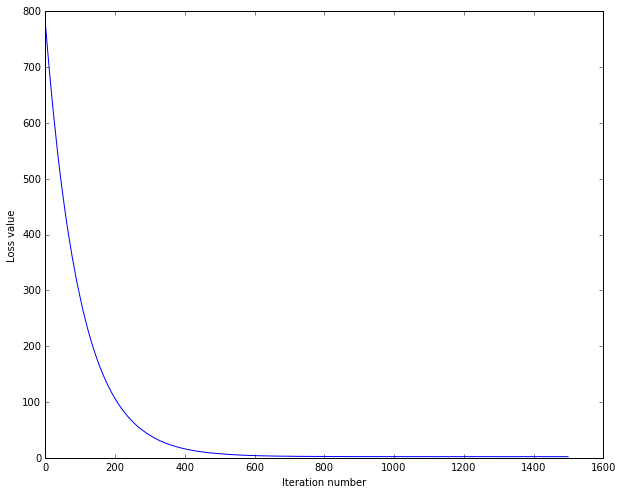

In [20]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for it in xrange(400):
# for lr in learning_rates:
#     for rs in regularization_strengths:
    lr=10**np.random.uniform(-8, -3)
    rs=10**np.random.uniform(2,8)
    print 'iter: {}, lr={}, rs={}'.format(it, lr, rs)
    smx = Softmax()
    smx.train(X_train, y_train, learning_rate=lr, reg=rs,
                  num_iters=1000, verbose=False)
    
    y_train_pred = smx.predict(X_train)
    train_accuracy=np.mean(y_train == y_train_pred)
    y_val_pred = smx.predict(X_val)
    val_accuracy=np.mean(y_val == y_val_pred)

    if val_accuracy>best_val:
        best_val=val_accuracy
        best_softmax=smx
    results[(lr, rs)]=(train_accuracy, val_accuracy)
    print train_accuracy, val_accuracy, best_val
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iter: 0, lr=2.32047425041e-08, rs=1986385.15453
0.268755102041 0.276 0.276
iter: 1, lr=2.05749114099e-06, rs=14512.4906309
0.355163265306 0.37 0.37
iter: 2, lr=1.27091922442e-07, rs=3178691.84266
0.233489795918 0.233 0.37
iter: 3, lr=1.87203458487e-08, rs=3712145.6463
0.250653061224 0.266 0.37
iter: 4, lr=4.87806898285e-08, rs=15420975.6568
0.234040816327 0.243 0.37
iter: 5, lr=2.1419202991e-05, rs=376635.116549
0.100265306122 0.087 0.37
iter: 6, lr=0.000176292744439, rs=1568213.38856
0.100265306122 0.087 0.37
iter: 7, lr=8.25374733676e-08, rs=139.971503032
0.225897959184 0.245 0.37
iter: 8, lr=7.97987512634e-07, rs=1798.73279124
0.388367346939 0.394 0.394
iter: 9, lr=1.4656598154e-05, rs=7008.27211563
0.190326530612 0.182 0.394
iter: 10, lr=0.00073823819441, rs=2100828.92237
0.100265306122 0.087 0.394
iter: 11, lr=0.000213766514332, rs=168166.167383
0.100265306122 0.087 0.394
iter: 12, lr=3.71508874136e-05, rs=12033158.625
0.100265306122 0.087 0.394
iter: 13, lr=5.94256272152e-05, rs=

In [22]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.386000


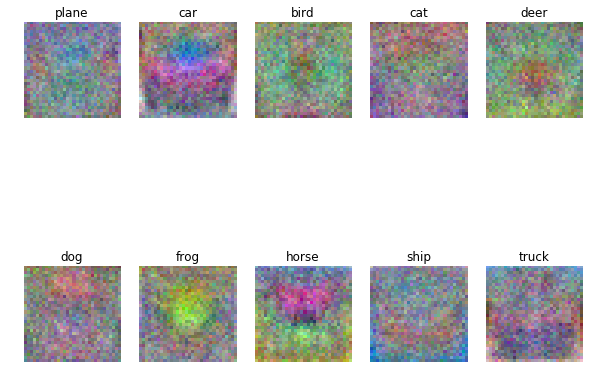

In [23]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])